# Time Series Analysis and Decomposition Using VAR

This notebook shows how enterprise time series can be forecasted and decomposed using vector autoregression (VAR) models. We are focusing on the analysis of covariates with memory effects such as price-demand dependencies in some domains. VAR model is a useful tool for that becasue of its ability to estimate impulse response functions (IRF) that highlight the dynamics of interactions between the observed series. 


# Background: VAR Model and Impulse Response Functions
---
Assuming that we observe $n$ time series &y_{it}&, the $p$-th order vector autoregressive model of dimension $n$ is defined as follows:
$$
\mathbf{y}_t = \mathbf{c} + \sum_{i=1}^p \mathbf{A}_i \mathbf{y}_{t-i} + \mathbf{u}_t
$$

where $\mathbf{c}$ is $1\times n$ vector of constants, $\mathbf{A}_i$ is a set of $n\times n$ matrics of regression coeffecients, and $\mathbf{u}_t$ is a $1\times n$ zro mean vector of innovations.

VAR(1) model for two time series and one time lag is shown below as an example: 
$$
y_{1,t} = c_{1} + a_{11,1}y_{1,t-1} + a_{12,1}y_{2,t-1}+u_{1,t} \\  
y_{2,t} = c_{2} + a_{21,1}y_{1,t-1} + a_{22,1}y_{2,t-1}+u_{2,t}
$$

The typical modeling process includes testing of the input time series for interdependencies using the Granger causality test, cointegration checks, model parameters selection, model fitting, model strcuture analysis, and forecasting. We go through these steps below.

---
Impulse responses are the estimated responses to a unit impulse in one of the variables. 

Suppose that the VAR is written is lag operator form as
$$
\mathbf{A}(B)\mathbf{y}_t = \mathbf{u}_t
$$

where $B$ is the lag operator and $\mathbf{A}$ is the lag polynomial in $B$:

$$
\mathbf{A}(B) = \mathbf{I}_n - \mathbf{A}_1B - \ldots - \mathbf{A}_p B^p
$$

Then we can define the vector moving average (MA) representation as

$$
\mathbf{y}_t = \mathbf{A}^{-1}(B)\mathbf{u}_t = \mathbf{\Psi}(B)\mathbf{u}_t = \mathbf{u}_t + \sum_{i=1}^\infty \mathbf{\Psi}_i \mathbf{u}_{t-i}
$$

where 

$$
\mathbf{\Psi}_i = \sum_{j=1}^i \mathbf{A}_j \mathbf{\Psi}_{i-j} \quad \mathbf{\Psi}_0 = \mathbf{I}_n \quad \mathbf{\Psi}_i=\mathbf{0} \quad i<0
$$

Conceptually, the response of $y_r$ to a unit shock in $y_s$ is given by the impulse respone function specified by the sequence $\phi_{rs,1}, \psi_{rs, 2}, \ldots$ where $\psi_{rs,i}$ is the $rs$-th elements of the matrix $\mathbf{\Psi}_i$. 

However, since the correlation matrix $\mathbf{\Omega}_p=E(\mathbf{u}_t\mathbf{u}_t')$ is not necessarily diagonal, the shock defined by the coeffecients $\psi$ is not separated from shocks that are correlated with $u_{s,t}$. Consequently, the MA representation is additionally renormalized using the Cholesky decomposition (orthogonalization) of the estimated error covariance matrix to obtain the valid impulse response function. More specifically, we define the lower triangular matrix $\mathbf{S}$ such that $\mathbf{S}\mathbf{S}' = \mathbf{\Omega}_p$ and define $\mathbf{v}_t = \mathbf{S}^{-1}\mathbf{u}_t$ so that the transformed errors $\mathbf{v}_t$ are orthogonal to each other and $E(\mathbf{v}_t\mathbf{v}_t') = \mathbf{I}_n$. The Ma representation is then renormalized as follows:

$$
\mathbf{y}_t=\sum_{i=0}^\infty(\mathbf{\Psi}_i\mathbf{S})(\mathbf{S}^{-1}\mathbf{u}_{t-i}) = \sum_{i=0}^\infty\mathbf{\Psi}_i^O\mathbf{v}_{t-i}
$$

where $\mathbf{\Psi}_i^O = \mathbf{\Psi}_i \mathbf{S}$ and the impulse response function is then given by the sequence $\psi^O_{rs,0}, \psi^O_{rs,1}, \ldots$

---
### References
* T. Mills, Applied Time Series Analysis, Academic Press, 2020

# Step 1: Generate the Data

We fist generate a data sample that simulates several effects that are commonly found in enterprise applications (e.g. sales data). More specifically, the generated series comprises the following components:
* Trend. Linear market trend. 
* Seasonality. Quarterly demand waves. 
* Covariates with a linear link function. External factors that have near-linear influence on the observed series. For instance, the relationship between price and demand is sometimes modeled as a linear fiunction. We assume that these covariates are observed directly. 
* Covariates with a non-linear link function. External factors that have non-linear influence on the observed signal. For instance, some common price-demand models are non-linear. We assume that the covariates are observed directly, but the non-linear link function is unknown. We use a steep sigmoid function as an example.  
* Covariates with memory effects. Some external factors can influce the observed signal with a delay. For example, deep discounts can boost current sales bu reduce future sales becasue of stockpiling. This can be modeled as a special type of a link function e.g. a convolution with some impulse response function. We observe the original covariate, but not the link function or transformed covariate. 

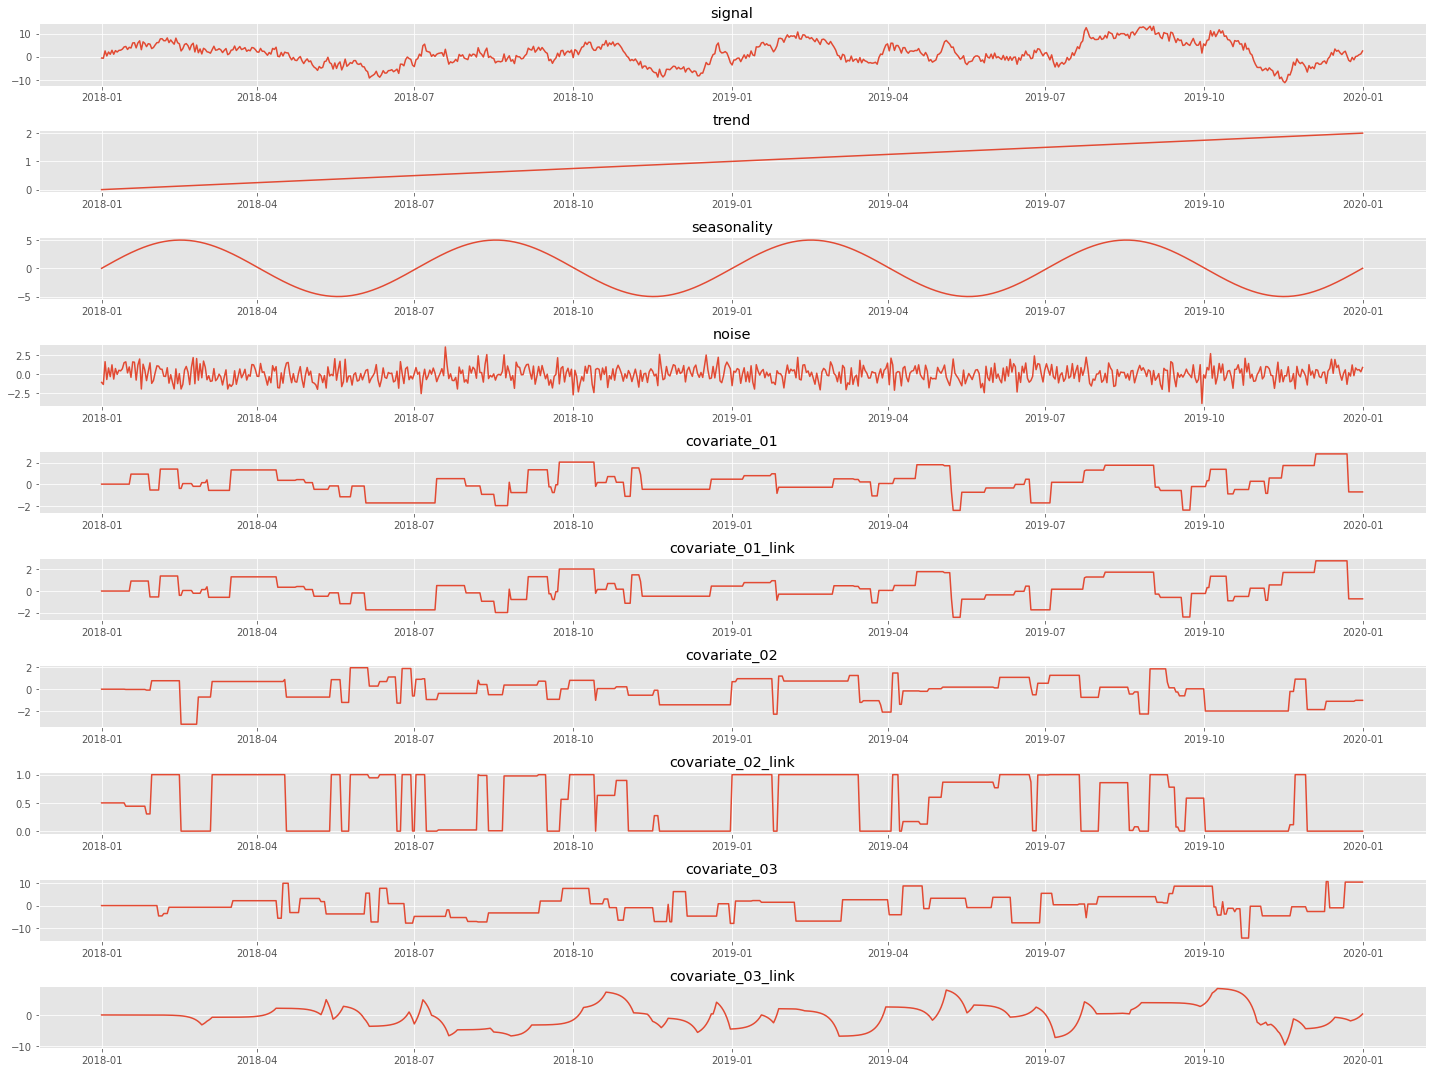

In [90]:
import numpy as np
import pandas as pd
import datetime
import collections
from matplotlib import pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

from statsmodels.tsa.api import VAR
    
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

def linear_link(x): 
    return x

def sigmoid_link(x, scale = 10):
    return 1 / (1 + np.exp(-scale*x))

def mem_link(x, length = 50):
    mfilter = np.exp(np.linspace(-10, 0, length))
    return np.convolve(x, mfilter/np.sum(mfilter), mode='same')

def create_signal(links = [linear_link, sigmoid_link, mem_link]):
    days_year = 365
    quaters_year = 4
    days_week = 7
    
    # two years of data, daily resolution
    idx = pd.date_range(start='2018-01-01', end='2020-01-01', freq='D') 

    df = pd.DataFrame(index=idx, dtype=float)
    df = df.fillna(0.0)
    
    n = len(df.index)
    trend = np.zeros(n)
    seasonality = np.zeros(n)
    for t in range(n):
        trend[t] = 2.0 * t/n
        seasonality[t] = 5.0 * np.sin(np.pi * t/days_year*quaters_year)
    
    covariates = [step_series(n, 0, 1.0, 80), step_series(n, 0, 1.0, 80), step_series(n, 0, 5.0, 80)]
    covariate_links = [ links[i](covariates[i]) for i in range(3) ]
    
    noise = np.random.randn(n)
    
    signal = trend + seasonality + np.sum(covariate_links, axis=0) + noise
    
    df['signal'], df['trend'], df['seasonality'], df['noise'] = signal, trend, seasonality, noise
    for i in range(3):
        df[f'covariate_0{i+1}'] = covariates[i]
        df[f'covariate_0{i+1}_link'] = covariate_links[i]
    
    return df

df = create_signal()
fig, ax = plt.subplots(len(df.columns), figsize=(20, 15))
for i, c in enumerate(df.columns):
    ax[i].plot(df.index, df[c])
    ax[i].set_title(c)

plt.tight_layout()
plt.show()

# Step 2: Fit the VAR model and visualize Impulse Response Functions

In this section, we user IRFs to analyze the difference between covariates without memory effects and covariates that have some delayes in the link function. 

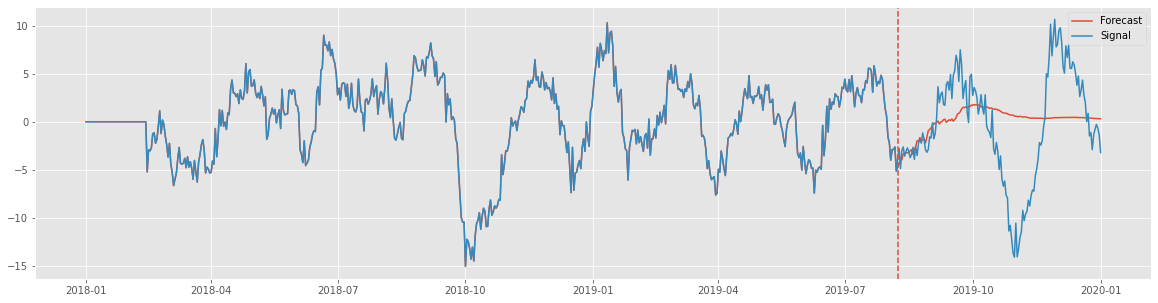

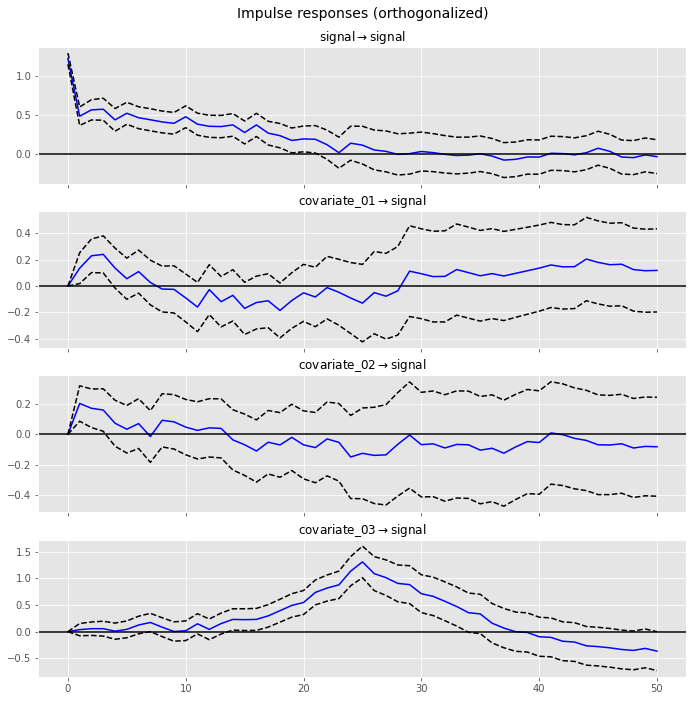

In [189]:
df = create_signal()

#
# subtract the rolling mean to remove trend/seasonality
#
df['signal'] = df['signal'] - df['signal'].rolling(int(len(df)/16)).mean()
df[np.isnan(df)] = 0

#
# fit the VAR model 
#
endog_cols = ['signal', 'covariate_01', 'covariate_02', 'covariate_03']  
df_endog = df[endog_cols]

split_t = int(len(df_endog) * 0.8)
idx_train, idx_test = df_endog.index[:split_t], df_endog.index[split_t:]
x_endog_train, x_endog_test = df_endog[:split_t], df_endog[split_t:]
model_var = VAR(endog = x_endog_train, dates = idx_train, freq = 'D')
model_var_fitted = model_var.fit(30, trend='c')

forecast_steps = len(x_endog_test)
forecast = model_var_fitted.forecast(y=x_endog_train.values, steps=forecast_steps)

#
# visualize the results
#
fig, ax = plt.subplots(1, figsize=(20, 5))
y_test_pred = np.concatenate([x_endog_train.values, forecast])
df_forecast = df.copy()
df_forecast['forecast'] = y_test_pred[:, 0]
        
ax.plot(df_forecast['forecast'], label='Forecast')
ax.plot(df_forecast['signal'], label='Signal')
ax.axvline(x=df_forecast.index[len(x_endog_train)], linestyle='--')
ax.legend()

irf = model_var_fitted.irf(50)
    
irf.plot(orth=True, response='signal');

The IRF plots above clearly indicate presence of the delayed effects in covariate 03 (spike at the true half-lenght of the convoluational filter).